# PRICE MINISTER : évaluation de l'utilité des commentaires

***

## Exploration et visualisation des données

On importe l'ensemble des modules dont on aura besoin pour la visualisation, le text mining ainsi que le ML

In [1]:
# Generic modules for loading data and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

On Charge les données:

In [2]:
# Get data
train = pd.read_csv("./train.csv",sep=';')
print("train : " + str(train.shape))
test = pd.read_csv("./test.csv",sep=';')
print("test : " + str(test.shape))

train : (60000, 6)
test : (20000, 5)


On jette un coup d'oeil à quoi ressemble les données

In [3]:
train.head()

,ID,review_content,review_title,review_stars,product,Target
0,0,En appelant un acheteur pour demander si l'écr...,La Police s'inscrit en acheteur privé sur Pric...,5,2fbb619e3606f9b7c213e858a109cda771aa2c47ce50d5...,0
1,1,"Alors, là, on a affaire au plus grand Navet ja...",Chef D'Oeuvre Absolu en vue...,5,7b56d9d378d9e999d293f301ac43d044cd7b4786d09afb...,1
2,2,Effet garanti sur la terrase. Ils donnent immé...,Effet garanti sur la terrase. Ils donnent immé...,3,7b37bf5dcb2fafd9229897910318a7dfa11a04ca36893c...,0
3,3,tres bon rapport qualite prix tre pratique en ...,bon produit,4,77d2dbd504b933ab3aaf7cb0cd81c22f7c3549012f4f88...,1
4,4,Ordinateur de bureau trés bien pour quelqu'un ...,Apple Power MAC G4,3,f574512e7d2dd1dd73c7f8f804bf16f14c932c5651a01b...,1


On vérifie qu'il ne manque pas de donnée

In [4]:
train.isnull().sum()

ID                0
review_content    0
review_title      0
review_stars      0
product           0
Target            0
dtype: int64

In [5]:
test.isnull().sum()

ID                0
review_content    0
review_title      0
review_stars      0
product           0
dtype: int64

On commence par regarder les statistiques de base sur les données numériques afin de voir ce qu'elle peuve nous donner.

In [6]:
train.describe()

,ID,review_stars,Target
count,60000.000000,60000.000000,60000.000000
mean,29999.500000,4.308667,0.554850
std,17320.652413,1.151512,0.496987
min,0.000000,1.000000,0.000000
25%,14999.750000,4.000000,0.000000
50%,29999.500000,5.000000,1.000000
75%,44999.250000,5.000000,1.000000
max,59999.000000,5.000000,1.000000


On a plutot des bonnes notes dans review_stars. On observe que les données sont plutot bien balancées. Le plus mauvais prédicteur sera à 55% en mettant tout le temps que l'avis est utile dans la classification.

Désormais, on va créer une classe pour la vérification des duplicatas, et la suppression des colonnes inutiles. On cré une classe dans un esprit générique, afin de ne pas répéter du code pour les données de train et de test.

In [7]:
class checkData():
    def __init__(self):
        pass
    def fit(self,X):
        pass
    def checkID(self,X):
# Check for duplicates in ID
        idsUnique = len(set(train.ID))
        idsTotal = train.shape[0]
        idsDupli = idsTotal - idsUnique
        print("There are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")       
    def dropUselessColumn(self,X):
# Drop ID column
        X.drop("ID", axis = 1, inplace = True)        
# Drop ID column
        X.drop("product", axis = 1, inplace = True)        

On vérifie que l'on a pas de duplicata dans nos données. Une fois cela fait, on va supprimer les colonnes pour le machine learning. On se garde toutefois la colonne ID de test dans un coin pour créer le fichier candidate submission

In [8]:
clr = checkData()

In [9]:
clr.checkID(train)

There are 0 duplicate IDs for 60000 total entries


In [10]:
clr.checkID(test)

There are 0 duplicate IDs for 60000 total entries


In [11]:
testID = test.ID

In [12]:
testID.head()

0    60000
1    60001
2    60002
3    60003
4    60004
Name: ID, dtype: int64

In [13]:
clr.dropUselessColumn(train)
clr.dropUselessColumn(test)

On regarde la distribution de review_stars afin de voir s'il a un intérêt dans la prédiction de Target

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001FB8D72EB38>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001FB8ECE16D8>], dtype=object)

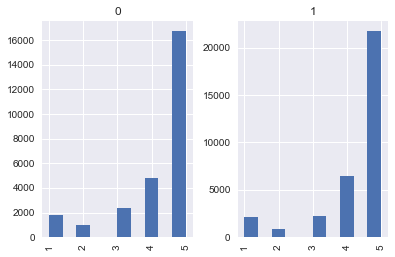

In [14]:
train['review_stars'].hist(by=train['Target'])

La distribution des review_stars pour chaque Target est à peu près identique. Cela ne nous aidera pas beaucoup pour la prédiction. On va désormais s'intéresser aux données textuelles, i.e. les colonnes review_content et review_title.

## Création des features : text mining

On commence par importer les modules dont on aura besoin pour la création de nos features.

In [15]:
# text mining modules
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem.porter import *
import string
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize

Dans un premier temps, je vais ajouter une fonction pour compter le nombre de mots, avec l'intuition que plus le texte est long plus il y a de chance qu'il soit pertinent.

In [16]:
def count_word(words):
    return len(words.split(' '))

Dans un second temps, je vais créer des fonctions pour l'analyse de sentiment du texte. La polarité et la subjectivité du commentaire ou du titre doivent certainement avoir une influence sur l'utilité.

In [17]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

In [18]:
def polarity(x):
    return tb(x).sentiment[0]
def subjectivity(x):
    return tb(x).sentiment[1]    

Une autre idée est de regarder la consistance des données. En d'autres termes, si un commentaire positif donne une note positive, cela semble correct et devrait donner lieu à un commentaire utile...

In [19]:
def dot_function(x,y):
    return x*y

Comme autre feature, on va regarder la consistance de contenue entre le titre et le commentaire.

In [20]:
stop_words_list = get_stop_words('french')

def rmP(x):
    p=set(string.punctuation)
    doc = x.lower()
    words = word_tokenize(doc,language='french')
    for i,j in enumerate(words):
        if len(j)>2:
            if j[2] in p:
                words[i]=j[3:]
        if len(j)>1:
            if j[1] in p:
                words[i]=j[2:]
        if len(j)==1:
            if j[0] in p:
                words[i]=' '
    doc = list(filter(lambda x: x not in stop_words_list,words))
#    doc =[ word for word in words if word not in stop_words_list  ]
# french stemming : use snowball...
#    stemmer=PorterStemmer()
#    for i,word in enumerate(doc):
#       doc[i]=stemmer.stem(word)
    return ' '.join(doc)

def text_similarity(x,y):
    docs = [x,y]
#use tfidfvectorizer
    vectorizer=TfidfVectorizer()
    try :
        vectorizer.fit(docs)
    except :
        return 0.
    Xtf_idf = vectorizer.transform([x]).toarray()    
    Ytf_idf = vectorizer.transform([y]).toarray()
    return cosine_similarity(Xtf_idf,Ytf_idf)

L'idée suivante est de regarder l'influence des 100 mots avec le plus grand tf_idf.
On va dans un premier temps merger nos données textes de test et de train. Puis nous allons regarder les 100 mots les plus utilisés. Ils seront utilisées comme variable catégorielle pour l'entrainement du classifieur.

In [21]:
def merge_text(x,y):
    return x+' '+y

In [22]:
merged_data = pd.concat([train.get(['review_content','review_title']),test.get(['review_content','review_title'])])

In [23]:
merged_data['merge_text']= np.vectorize(merge_text)(merged_data['review_content'],merged_data['review_title'])

In [24]:
vect = TfidfVectorizer(stop_words= stop_words_list)
X = vect.fit_transform(merged_data['merge_text'])

In [25]:
indices = np.argsort(vect.idf_)[::]
features = vect.get_feature_names()
top_n = 100
top_features = [features[i] for i in indices[:top_n]]
print(top_features)

['bien', 'plus', 'qualité', 'produit', 'bonne', 'prix', 'tres', 'super', 'vraiment', 'belle', 'pratique', 'petit', 'excellent', 'rien', 'parfait', 'rapport', 'beau', 'facile', 'rapide', 'trés', 'toute', 'assez', 'livre', 'superbe', 'beaucoup', 'photo', 'merci', 'magnifique', 'autres', 'simple', 'faut', 'grand', 'collection', 'recommande', 'utilisation', 'temps', 'carte', 'jeu', 'toujours', 'appareil', 'acheter', 'permet', 'film', 'trouve', 'mal', 'achat', 'dire', 'cher', 'reste', 'surtout', 'agréable', 'grande', 'seul', 'toutes', 'voir', 'petite', 'jolie', 'entre', 'non', 'idéal', 'couleur', 'top', 'rare', 'mieux', 'jeux', 'fans', 'article', 'après', 'ans', 'album', 'marque', 'taille', 'mettre', 'photos', 'avis', 'jamais', 'dommage', 'sympa', 'efficace', 'histoire', 'meme', 'série', 'plaisir', 'vrai', 'joli', 'monde', 'fonctionne', 'utiliser', 'attention', 'enfants', 'meilleur', 'solide', 'génial', 'adore', 'aime', 'lire', 'quelques', 'indispensable', 'celui', 'excellente']


Pour la creation des features, et toujours dans un esprit générique. Je vais créer une classe:

In [26]:
class createFeature():
    def __init__(self):
        pass
    def create_count_word(self,X):
        X['count_content'] = X['review_content'].apply(count_word)
        X['count_title'] = X['review_title'].apply(count_word)
    def sentiment_analysis(self,X):
        X['polarity_content'] = X['review_content'].apply(polarity)
        X['polarity_title'] = X['review_title'].apply(polarity)
        X['subjectivity_content'] = X['review_content'].apply(subjectivity)
        X['subjectivity_title'] = X['review_title'].apply(subjectivity)
    def consistency(self,X):
        X['dot_pol_content']=np.vectorize(dot_function)(X['review_stars'],X['polarity_content'])
        X['dot_sub_content']=np.vectorize(dot_function)(X['review_stars'],X['subjectivity_content'])
        X['dot_pol_title']=np.vectorize(dot_function)(X['review_stars'],X['polarity_title'])
        X['dot_sub_title']=np.vectorize(dot_function)(X['review_stars'],X['subjectivity_title'])
        X['dot_pol_title_content']=np.vectorize(dot_function)(X['polarity_content'],X['polarity_title'])
    def text_similarity(self,X):
        X['review_content2']= X['review_content'].apply(rmP)
        X['review_title2']= X['review_title'].apply(rmP)
        X['text_similarity']= np.vectorize(text_similarity)(X['review_content2'],X['review_title2'])

On cré les features:

In [27]:
crf = createFeature()
crf.create_count_word(train)
crf.sentiment_analysis(train)
crf.consistency(train)
crf.text_similarity(train)
crf.create_count_word(test)
crf.sentiment_analysis(test)
crf.consistency(test)
crf.text_similarity(test)


In [28]:
def check_word(x):
    list_words = x.split()
    if word in list_words:
        return 1.0
    else:
        return 0.0

for word in top_features:
    train[word] = merged_data['merge_text'].apply(check_word)[:60000]    
    test[word] = merged_data['merge_text'].apply(check_word)[60000:]

On vérifie avant de passer au machine learning que nos données sont propres

In [29]:
train.isnull().sum()

review_content           0
review_title             0
review_stars             0
Target                   0
count_content            0
count_title              0
polarity_content         0
polarity_title           0
subjectivity_content     0
subjectivity_title       0
dot_pol_content          0
dot_sub_content          0
dot_pol_title            0
dot_sub_title            0
dot_pol_title_content    0
review_content2          0
review_title2            0
text_similarity          0
bien                     0
plus                     0
qualité                  0
produit                  0
bonne                    0
prix                     0
tres                     0
super                    0
vraiment                 0
belle                    0
pratique                 0
petit                    0
                        ..
marque                   0
taille                   0
mettre                   0
photos                   0
avis                     0
jamais                   0
d

In [30]:
test.isnull().sum()

review_content           0
review_title             0
review_stars             0
count_content            0
count_title              0
polarity_content         0
polarity_title           0
subjectivity_content     0
subjectivity_title       0
dot_pol_content          0
dot_sub_content          0
dot_pol_title            0
dot_sub_title            0
dot_pol_title_content    0
review_content2          0
review_title2            0
text_similarity          0
bien                     0
plus                     0
qualité                  0
produit                  0
bonne                    0
prix                     0
tres                     0
super                    0
vraiment                 0
belle                    0
pratique                 0
petit                    0
excellent                0
                        ..
marque                   0
taille                   0
mettre                   0
photos                   0
avis                     0
jamais                   0
d

## Machine Learning : Classification à l'aide d'un Random Forest

Mon choix s'est orienté vers ce classifieur d'amblée parce qu'il est très robuste à l'overfitting. Par ailleurs, il permet de donner l'importance de chaque feature dans sa classification.

In [31]:
# ML imports
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.ensemble as ske
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

On élimine les colonnes non numériques:

In [32]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
train = train[numeric_feats]

In [33]:
y = train.Target 
# Drop Target column
train.drop("Target", axis = 1, inplace = True) 

On regarde la corrélation des données:

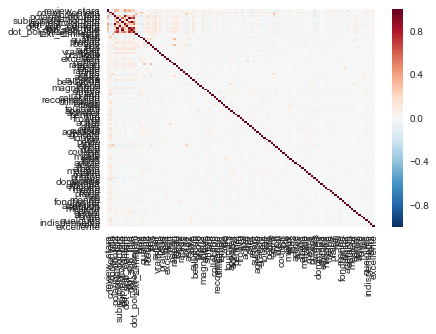

In [34]:
train_corr = pd.concat([train],axis=1)
corr = train_corr.corr()

sns.heatmap(corr)


Les données ont l'air assez indépendantes dans l'ensemble, sauf pour les données de consistences qui sont là seulement pour de l'ajustement.

On évalue notre classification sur les données train via roc_auc_score:

In [35]:
skf =StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
for train_is,test_is in skf.split(train,y):
    X_train = train.iloc[train_is]
    y_train = y.iloc[train_is]
    X_test = train.iloc[test_is]
    y_test = y.iloc[test_is]
    clf = ske.RandomForestClassifier(n_estimators=100,random_state=0)
    clf.fit(X_train,y_train)
    y_proba = clf.predict_proba(X_test)
    print('roc auc score', roc_auc_score(y_test,y_proba[:,1]))
    y_predic = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_predic)
    print(cm)
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_features = 10
    for f in range(top_features):
        print("%d. feature %d (%f)"%(f+1,indices[f],importances[indices[f]]))

roc auc score 0.678465151833
[[ 6417  6938]
 [ 4138 12507]]
1. feature 1 (0.090324)
2. feature 7 (0.077377)
3. feature 3 (0.077168)
4. feature 8 (0.070970)
5. feature 5 (0.069973)
6. feature 12 (0.052991)
7. feature 2 (0.045544)
8. feature 11 (0.044229)
9. feature 9 (0.031535)
10. feature 4 (0.029502)
roc auc score 0.672749124217
[[ 6240  7115]
 [ 4126 12519]]
1. feature 1 (0.092666)
2. feature 3 (0.077743)
3. feature 7 (0.077599)
4. feature 8 (0.070475)
5. feature 5 (0.069527)
6. feature 12 (0.053409)
7. feature 2 (0.046327)
8. feature 11 (0.044061)
9. feature 9 (0.031621)
10. feature 4 (0.029711)
roc auc score 0.672667453088
[[ 6316  7039]
 [ 4240 12405]]
1. feature 1 (0.089763)
2. feature 3 (0.077414)
3. feature 7 (0.076791)
4. feature 5 (0.070597)
5. feature 8 (0.069779)
6. feature 12 (0.054885)
7. feature 2 (0.047281)
8. feature 11 (0.043537)
9. feature 9 (0.031717)
10. feature 10 (0.030316)
roc auc score 0.671175397354
[[ 6198  7157]
 [ 4168 12477]]
1. feature 1 (0.091143)
2. fea

Finalement, on évalue notre modèle sur les données test:

In [36]:
numeric_feats = test.dtypes[test.dtypes != "object"].index
test = test[numeric_feats]

In [37]:
clf = ske.RandomForestClassifier(n_estimators=100,random_state=0)
clf.fit(train,y)
y_proba = clf.predict_proba(test)

On extraie la probabilité que l'avis soit de classe 1. Puis on cré le dataframe de sortie result_data, pour enregister le résultat dans le fichier csv

In [38]:
prob_utile = np.zeros(test.shape[0])
i = 0
for proba0,proba1 in y_proba:
    prob_utile[i]= proba1
    i=i+1

In [39]:
prob_utile_data = pd.DataFrame({'Target':prob_utile})

In [40]:
result_data = pd.concat([testID,prob_utile_data],axis=1)

In [41]:
result_data.set_index('ID',inplace=True)

In [42]:
result_data.to_csv('sylvain_submission.csv',sep=';')